In [1]:
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def identify_back_to_back(matchups_df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies back-to-back games for each team and adds B2B indicator columns.
    Also adds columns for days of rest for each team.

    Args:
        matchups_df (pd.DataFrame): DataFrame containing game information with columns
            'date', 'away', 'home'

    Returns:
        pd.DataFrame: Updated DataFrame with 'a_b2b', 'h_b2b', 'a_rest', 
            'h_rest' columns added
    """
    # Create copy to avoid modifying original
    df = matchups_df.copy()
    
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    def get_team_rest_info(team_games: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
        """Calculate B2B indicator and days of rest for a team's games"""
        team_games = team_games.sort_values('date')
        days_between = (team_games['date'] - team_games['date'].shift(1)).dt.days
        
        # B2B is when there's 1 day between games
        b2b = (days_between == 1).astype(int)
        
        # Days of rest (null for first game of season)
        rest = days_between - 1
        
        return b2b, rest

    # Initialize new columns
    df['a_b2b'] = 0
    df['h_b2b'] = 0
    df['a_rest'] = None
    df['h_rest'] = None

    # Process each team
    all_teams = set(df['away'].unique()) | set(df['home'].unique())
    for team in all_teams:
        # Get all games for the team (both home and away)
        team_games = df[(df['away'] == team) | (df['home'] == team)].copy()
        b2b, rest = get_team_rest_info(team_games)
        
        # Update away games
        away_mask = df['away'] == team
        df.loc[away_mask, 'a_b2b'] = b2b[team_games['away'] == team].values
        df.loc[away_mask, 'a_rest'] = rest[team_games['away'] == team].values
        
        # Update home games
        home_mask = df['home'] == team
        df.loc[home_mask, 'h_b2b'] = b2b[team_games['home'] == team].values
        df.loc[home_mask, 'h_rest'] = rest[team_games['home'] == team].values

    return df

In [3]:
matchups = pd.read_csv(r'../data/ash_01_n15_ml_11-01-24_12-31-24.csv')
matchups.rename(columns={'away_team': 'away',
                            'home_team': 'home',
                            'date': 'date',
                            'away_x_goals': 'a_x_goals',
                            'home_x_goals': 'h_x_goals',
                            'away_adj%': 'a_adj%',
                            'home_adj%': 'h_adj%',
                            'away_pred_goals': 'a_pred_goals',
                            'home_pred_goals': 'h_pred_goals',
                            'away_win_prob': 'a_win_prob',
                            'home_win_prob': 'h_win_prob',
                            'away_moneyline_odds': 'a_ml_odds',
                            'home_moneyline_odds': 'h_ml_odds',
                            }, inplace=True)

In [4]:
matchups.head()

,date,game_id,away,home,a_x_goals,a_adj%,h_x_goals,h_adj%,a_pred_goals,h_pred_goals,a_win_prob,h_win_prob,a_ml_odds,h_ml_odds,a_score,h_score,res
0,2024-11-02,2024020174,DAL,FLA,2.832456,0.980179,2.827360,0.952513,2.697951,2.771320,0.433371,0.566629,-110.0,-110.0,2,4,h
1,2024-11-02,2024020175,BOS,PHI,2.083253,0.964370,2.200495,0.822086,1.712613,2.122092,0.372122,0.627878,-128.0,106.0,3,0,a
2,2024-11-02,2024020176,CHI,LAK,2.538116,1.075035,3.265839,0.881371,2.237022,3.510893,0.235239,0.764761,155.0,-188.0,4,3,a
3,2024-11-02,2024020177,CBJ,WSH,2.017497,1.082940,3.033081,0.964370,1.945613,3.284645,0.226461,0.773539,220.0,-275.0,2,7,h
4,2024-11-02,2024020178,SEA,OTT,2.099344,1.055274,2.207407,1.134320,2.381328,2.329419,0.456843,0.543157,104.0,-125.0,0,3,h


In [5]:
matchups = identify_back_to_back(matchups)
matchups

,date,game_id,away,home,a_x_goals,a_adj%,h_x_goals,h_adj%,a_pred_goals,h_pred_goals,...,h_win_prob,a_ml_odds,h_ml_odds,a_score,h_score,res,a_b2b,h_b2b,a_rest,h_rest
0,2024-11-02,2024020174,DAL,FLA,2.832456,0.980179,2.827360,0.952513,2.697951,2.771320,...,0.566629,-110.0,-110.0,2,4,h,0,0,NaN,NaN
1,2024-11-02,2024020175,BOS,PHI,2.083253,0.964370,2.200495,0.822086,1.712613,2.122092,...,0.627878,-128.0,106.0,3,0,a,0,0,NaN,NaN
2,2024-11-02,2024020176,CHI,LAK,2.538116,1.075035,3.265839,0.881371,2.237022,3.510893,...,0.764761,155.0,-188.0,4,3,a,0,0,NaN,NaN
3,2024-11-02,2024020177,CBJ,WSH,2.017497,1.082940,3.033081,0.964370,1.945613,3.284645,...,0.773539,220.0,-275.0,2,7,h,0,0,NaN,NaN
4,2024-11-02,2024020178,SEA,OTT,2.099344,1.055274,2.207407,1.134320,2.381328,2.329419,...,0.543157,104.0,-125.0,0,3,h,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,2024-12-31,2024020597,WPG,COL,2.932707,1.442785,2.483553,0.990924,2.906089,3.583232,...,0.673973,172.0,-210.0,2,5,h,1,0,0.0,3.0
375,2024-12-31,2024020598,NJD,ANA,2.940491,0.864085,2.702884,1.050379,3.088630,2.335523,...,0.411212,-285.0,230.0,2,3,h,0,0,3.0,1.0
376,2024-12-31,2024020599,PHI,SJS,2.445574,0.673828,2.030340,1.185145,2.898359,1.368100,...,0.279166,-182.0,150.0,4,0,a,0,0,1.0,3.0
377,2024-12-31,2024020600,VAN,CGY,2.305257,0.903722,2.725536,0.975069,2.247785,2.463128,...,0.592867,112.0,-134.0,1,3,h,0,0,7.0,1.0


In [7]:
# matchups.value_counts('a_b2b')
matchups.value_counts('h_b2b')  


h_b2b
0    353
1     26
Name: count, dtype: int64

## 2. **Analyze Performance Metrics**Once B2B indicators are in place, analyze how performance metrics differ between B2B and non-B2B games.### **Metrics to Consider:**- **Win/Loss Rates:** Compare the winning percentages of teams in B2B scenarios versus regular games.- **Goals Scored & Allowed:** Assess if teams score fewer goals or allow more when playing back-to-back.- **Player Statistics:** Analyze individual player performance metrics, such as time on ice (TOI), shots, and penalties.### **Sample Analysis:**python

C:\Users\H-100\AppData\Local\Temp\ipykernel_33708\473897891.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='a_b2b', y='away_win_rate', data=away_win_rates, palette='Blues')


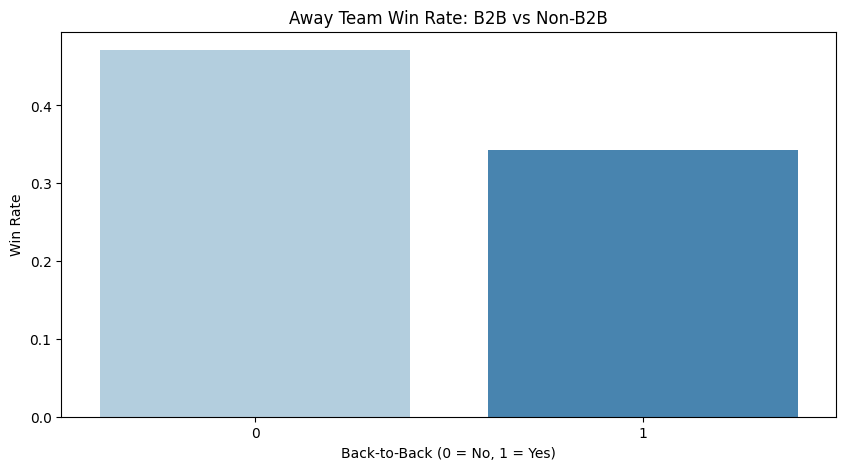

C:\Users\H-100\AppData\Local\Temp\ipykernel_33708\473897891.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='h_b2b', y='home_win_rate', data=home_win_rates, palette='Greens')


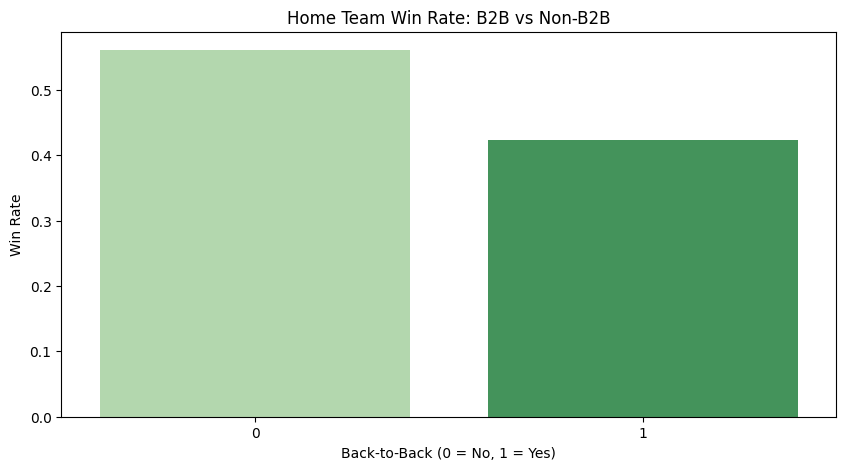

C:\Users\H-100\AppData\Local\Temp\ipykernel_33708\473897891.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='a_b2b', y='a_score', data=matchups, palette='Blues')


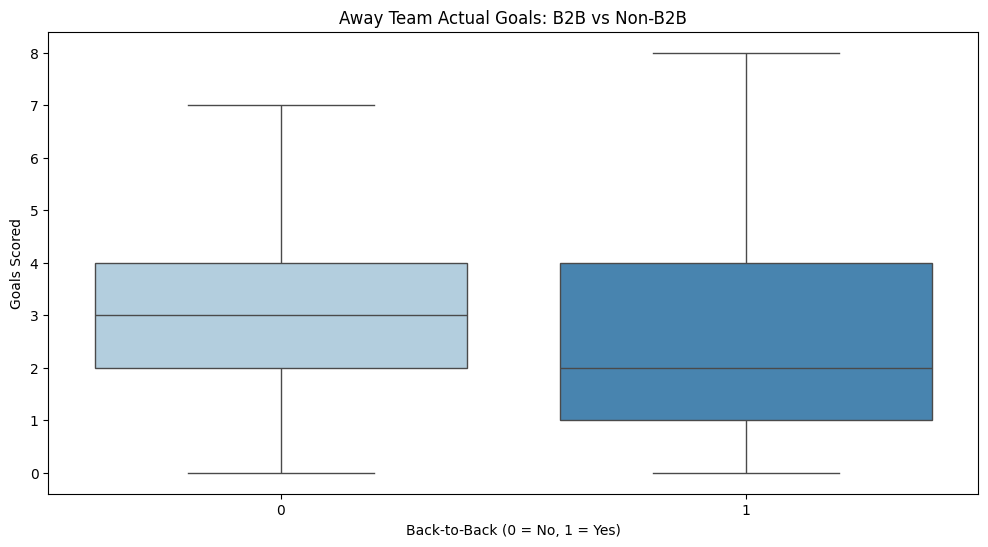

C:\Users\H-100\AppData\Local\Temp\ipykernel_33708\473897891.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='h_b2b', y='h_score', data=matchups, palette='Greens')


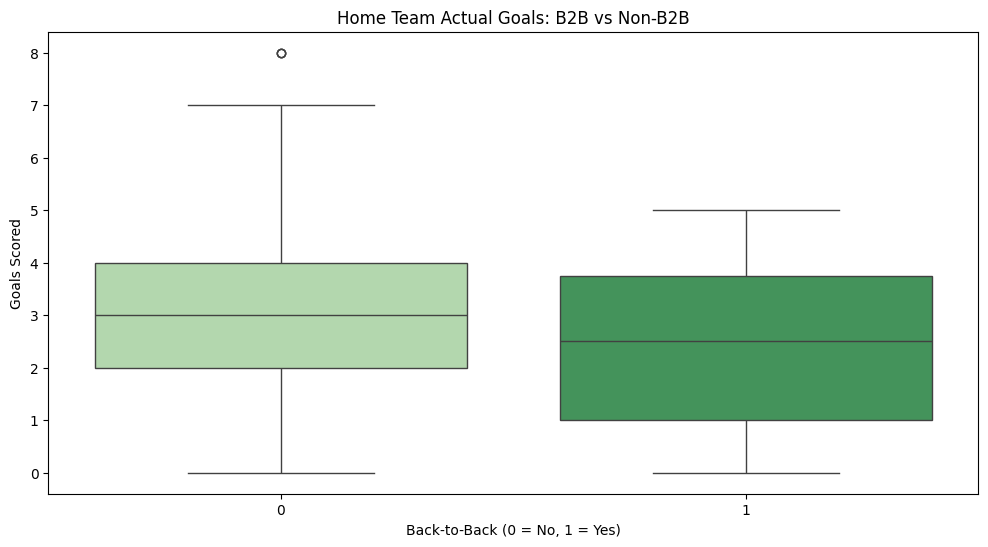

In [14]:
# Win/Loss Rates
away_win_rates = matchups.groupby('a_b2b')['res'].apply(lambda x: (x == 'a').mean()).reset_index(name='away_win_rate')
home_win_rates = matchups.groupby('h_b2b')['res'].apply(lambda x: (x == 'h').mean()).reset_index(name='home_win_rate')

plt.figure(figsize=(10,5))
sns.barplot(x='a_b2b', y='away_win_rate', data=away_win_rates, palette='Blues')
plt.title('Away Team Win Rate: B2B vs Non-B2B')
plt.xlabel('Back-to-Back (0 = No, 1 = Yes)')
plt.ylabel('Win Rate')
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(x='h_b2b', y='home_win_rate', data=home_win_rates, palette='Greens')
plt.title('Home Team Win Rate: B2B vs Non-B2B')
plt.xlabel('Back-to-Back (0 = No, 1 = Yes)')
plt.ylabel('Win Rate')
plt.show()

# Goals Scored
# Actual Goals Scored (changed from x_goals)
plt.figure(figsize=(12,6))
sns.boxplot(x='a_b2b', y='a_score', data=matchups, palette='Blues')
plt.title('Away Team Actual Goals: B2B vs Non-B2B')
plt.xlabel('Back-to-Back (0 = No, 1 = Yes)')
plt.ylabel('Goals Scored')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='h_b2b', y='h_score', data=matchups, palette='Greens')
plt.title('Home Team Actual Goals: B2B vs Non-B2B')
plt.xlabel('Back-to-Back (0 = No, 1 = Yes)')
plt.ylabel('Goals Scored')
plt.show()

## 3. **Incorporate B2B into Predictive Models**Integrate the B2B indicators as features in your predictive models to assess their impact and significance.###
**Steps:**
1. **Feature Engineering:** - Use the away_B2B and home_B2B as binary features. - Consider interaction terms (e.g., both teams on B2B).
2. **Model Training:** - Retrain your predictive models with the new features. - Evaluate feature importance to understand the impact of B2B.
3. **Performance Metrics:** - Analyze changes in model performance (e.g., accuracy, log loss) with the inclusion of B2B features.


              precision    recall  f1-score   support

           0       0.52      0.47      0.49        34
           1       0.60      0.64      0.62        42

    accuracy                           0.57        76
   macro avg       0.56      0.56      0.56        76
weighted avg       0.56      0.57      0.56        76

ROC AUC Score: 0.5669


C:\Users\H-100\AppData\Local\Temp\ipykernel_33708\600334609.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


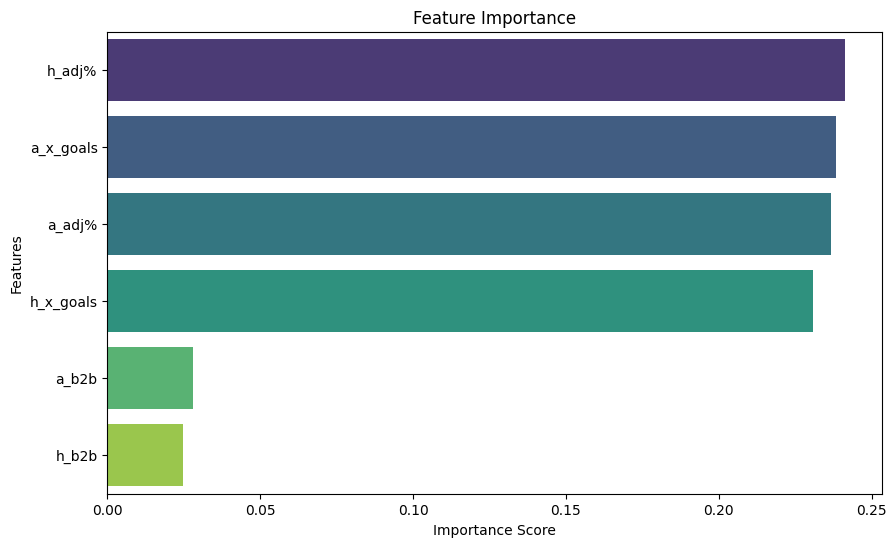

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Example: Predicting Home Win

# Define feature columns
feature_cols = [
    'a_x_goals', 'a_adj%', 'h_x_goals', 'h_adj%',
    'a_b2b', 'h_b2b'  # B2B indicators
    # Add other relevant features
]

X = matchups[feature_cols]
y = matchups['res'].apply(lambda x: 1 if x == 'h' else 0)  # Binary target: Home win

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluation
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Feature Importance
importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## 4.
**Advanced Statistical Analysis**Beyond feature inclusion, perform statistical tests to determine the significance of B2B effects.###
**Chi-Square Test for Independence:**Assess whether there's a significant association between B2B status and game outcomes.python

In [16]:
from scipy.stats import chi2_contingency

# Contingency table for Home Team
contingency_home = pd.crosstab(matchups['h_b2b'], matchups['res'])
chi2, p, dof, ex = chi2_contingency(contingency_home)

print(f"Chi-Square Test for Home Team B2B vs Outcome:")
print(f"Chi2 Statistic: {chi2}, p-value: {p}")

# Interpretation
if p < 0.05:
    print("Reject the null hypothesis: Significant association between Home B2B and game outcome.")
else:
    print("Fail to reject the null hypothesis: No significant association between Home B2B and game outcome.")

Chi-Square Test for Home Team B2B vs Outcome:
Chi2 Statistic: 1.3443637039207719, p-value: 0.24626588383491543
Fail to reject the null hypothesis: No significant association between Home B2B and game outcome.


### **T-Test for Mean Comparison:**Compare mean performance metrics (e.g., x_Goals) between B2B and non-B2B games.python

In [17]:
from scipy.stats import ttest_ind

# Home Team actual goals
b2b_home = matchups[matchups['h_b2b'] == 1]['h_score']
non_b2b_home = matchups[matchups['h_b2b'] == 0]['h_score']

t_stat, p_val = ttest_ind(b2b_home, non_b2b_home, equal_var=False)
print(f"T-Test for Home actual goals between B2B and Non-B2B:")
print(f"T-Statistic: {t_stat}, p-value: {p_val}")

# Interpretation
if p_val < 0.05:
    print("Significant difference in Home actual goals between B2B and Non-B2B games.")
else:
    print("No significant difference in Home actual goals between B2B and Non-B2B games.")

# You might also want to look at away teams
b2b_away = matchups[matchups['a_b2b'] == 1]['a_score']
non_b2b_away = matchups[matchups['a_b2b'] == 0]['a_score']

t_stat_away, p_val_away = ttest_ind(b2b_away, non_b2b_away, equal_var=False)
print(f"\nT-Test for Away actual goals between B2B and Non-B2B:")
print(f"T-Statistic: {t_stat_away}, p-value: {p_val_away}")

# Interpretation
if p_val_away < 0.05:
    print("Significant difference in Away actual goals between B2B and Non-B2B games.")
else:
    print("No significant difference in Away actual goals between B2B and Non-B2B games.")

T-Test for Home actual goals between B2B and Non-B2B:
T-Statistic: -2.0420477765338965, p-value: 0.0504772058956354
No significant difference in Home actual goals between B2B and Non-B2B games.

T-Test for Away actual goals between B2B and Non-B2B:
T-Statistic: -1.9672037141254346, p-value: 0.05195495566348753
No significant difference in Away actual goals between B2B and Non-B2B games.


## 5. **Visualization of Trends**Visualize trends to understand the impact of B2B on various metrics over time.### **Time Series Analysis:**Plot rolling averages of performance metrics, distinguishing between B2B and non-B2B games.python

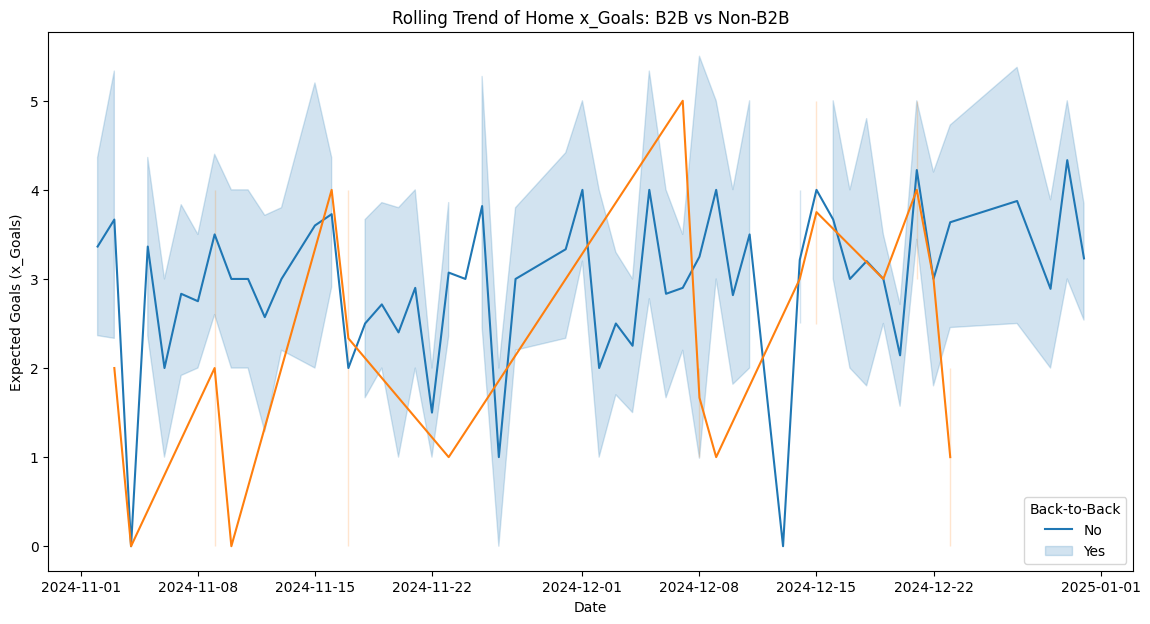

In [19]:
# Example: Rolling Average of Home x_Goals

matchups_sorted = matchups.sort_values('date')

plt.figure(figsize=(14,7))
sns.lineplot(data=matchups_sorted, x='date', y='h_score', hue='h_b2b')
plt.title('Rolling Trend of Home Sc: B2B vs Non-B2B')
plt.xlabel('Date')
plt.ylabel('Expected Goals (x_Goals)')
plt.legend(title='Back-to-Back', labels=['No', 'Yes'])
plt.show()

## 6. **Incorporate Rest as a Continuous Variable**Instead of a binary B2B indicator, consider quantifying rest days as a continuous variable, which can capture varying degrees of fatigue.### **Implementation Steps:**1. **Calculate Days Since Last Game:** - For each team, compute the number of days since their last game.2. **Add as a Feature:** - Use this value directly or transform it (e.g., logarithmic scale) for modeling.### **Sample Code:**python

In [ ]:
# def calculate_days_since_last_game(matchups_df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Calculates the number of days since the last game for both away and home teams.

#     Args:
#         matchups_df (pd.DataFrame): DataFrame containing game information with 'date', 'away_team', and 'home_team' columns.

#     Returns:
#         pd.DataFrame: Updated DataFrame with 'days_since_last_game_away' and 'days_since_last_game_home' columns added.
#     """
#     matchups_df['date'] = pd.to_datetime(matchups_df['date'])

#     def get_days_since_last(team_games: pd.DataFrame, team_type: str) -> pd.Series:
#         team_games = team_games.sort_values('date')
#         team_games[f'days_since_last_game_{team_type}'] = team_games['date'].diff().dt.days
#         # Fill the first game with a default value, e.g., 7 days
#         team_games[f'days_since_last_game_{team_type}'].fillna(7, inplace=True)
#         return team_games[f'days_since_last_game_{team_type}']

#     # Calculate for away teams
#     away_teams = matchups_df['away_team'].unique()
#     matchups_df['days_since_last_game_away'] = 7  # Default value
#     for team in away_teams:
#         team_games = matchups_df[matchups_df['away_team'] == team]
#         days_since = get_days_since_last(team_games, 'away')
#         matchups_df.loc[team_games.index, 'days_since_last_game_away'] = days_since

#     # Calculate for home teams
#     home_teams = matchups_df['home_team'].unique()
#     matchups_df['days_since_last_game_home'] = 7  # Default value
#     for team in home_teams:
#         team_games = matchups_df[matchups_df['home_team'] == team]
#         days_since = get_days_since_last(team_games, 'home')
#         matchups_df.loc[team_games.index, 'days_since_last_game_home'] = days_since

#     return matchups_df

## 7. **Model Interpretation and Impact Assessment**After incorporating B2B features, assess their impact through model interpretation techniques.### **Using SHAP for Feature Importance:**SHAP (SHapley Additive exPlanations) can help visualize the contribution of each feature to the model's predictions.python

In [ ]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

### **Partial Dependence Plots:**Visualize how changes in B2B features affect the predicted probabilities.python

In [ ]:
from sklearn.inspection import plot_partial_dependence

# Partial dependence for B2B features
features = ['a_b2b', 'h_b2b']
plot_partial_dependence(model, X_train, features)
plt.show()

## 8. **Potential Challenges and Considerations**- **Sample Size:** Ensure there are enough B2B games in your dataset to make statistically significant conclusions.- **Confounding Variables:** Other factors (e.g., travel distance, injuries) might influence both B2B status and game outcomes. Consider including these as additional features.- **Interaction Effects:** The impact of B2B might differ based on other variables like team strength or player depth. Explore interaction terms in your models.## 9. **Extending to Player-Level Analysis**If you're interested in the impact of B2B at the player level (e.g., individual performance metrics), follow a similar approach:1. **Determine Player B2B Status:** - Calculate if the player participated in consecutive games.2. **Analyze Player Performance:** - Compare metrics like TOI, shots, or points between B2B and non-B2B games.3. **Incorporate into Player Models:** - Use B2B status as a feature in models predicting player performance.### **Sample Code:**python

In [ ]:
def identify_player_back_to_back(player_stats_df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies back-to-back games for each player and adds a B2B indicator column.

    Args:
        player_stats_df (pd.DataFrame): DataFrame containing player game performance with 'player_id' and 'date' columns.

    Returns:
        pd.DataFrame: Updated DataFrame with 'player_B2B' column added.
    """
    player_stats_df['date'] = pd.to_datetime(player_stats_df['date'])
    
    def get_player_b2b(team_games: pd.DataFrame) -> pd.Series:
        team_games = team_games.sort_values('date')
        previous_game_date = team_games['date'].shift(1)
        b2b = (team_games['date'] - previous_game_date) == timedelta(days=1)
        return b2b.astype(int)
    
    player_stats_df['player_B2B'] = 0
    players = player_stats_df['player_id'].unique()
    for player in players:
        player_games = player_stats_df[player_stats_df['player_id'] == player]
        b2b = get_player_b2b(player_games)
        player_stats_df.loc[player_games.index, 'player_B2B'] = b2b
    
    return player_stats_df

## 10.
**Documentation and Reporting**Ensure that all analyses, assumptions, and findings related to B2B effects are well-documented. Create reports or dashboards to visualize and communicate the impact effectively.###
**Sample Reporting Steps:**
1. **Summary Statistics:** - Present key statistics comparing B2B and non-B2B scenarios.
2. **Visualizations:** - Include charts and graphs that highlight differences in performance metrics.
3. **Model Insights:** - Discuss the significance and impact of B2B features in predictive models.
4. **Recommendations:** - Provide actionable insights, such as adjusting predictions based on upcoming B2B games.## ConclusionIncorporating and quantifying the effect of back-to-back games involves several steps, from data processing to model integration and analysis. By following the methodologies outlined above, you can effectively measure and leverage the impact of B2B scenarios to enhance your predictive models and gain deeper insights into team performance dynamics.Feel free to adapt and expand upon these suggestions based on the specific requirements and nuances of your dataset and modeling objectives.